In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


### The tiny-YOLO v1

#### Model Architecture

The model architecture consists of 9 convolutional layers, followed by 3 fully connected layers.
Each convolutional layer is followed by a Leaky RELU activation function, with alpha of 0.1.
The first 6 convolutional layers also have a 2x2 max pooling layers.

In [2]:
# Pre trained weights require this ordering (Theano)
keras.backend.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

#### Normalization And Preprocessing of Image

* Input to the model is a batch of 448x448 images. So we first determine the area of interest for each image. We only consider this portion of the image for prediction, since cars won't be present all over the image, just on the roads in the lower portion of the image. Then this cropped image is resized to a 448x448 image.

* Each image pixel is normalized to have values between -1 and 1. We use simple min-max normalization to achieve this.

In [3]:
def crop_and_resize(image):
    cropped = image[300:650,500:,:]
    return cv2.resize(cropped, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

#### Drawing Bounding box on Images with Vehicle 

* This includes thresholding class score , removing dulipcate bounding boxes based on the confidence level and IOU

In [4]:

class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
        
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    print ('============== BOX_IOU ',box_intersection(a, b) / box_union(a, b))
    return box_intersection(a, b) / box_union(a, b)



def yolo_output_to_car_boxes(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):
    print (' INside yolo_output_to_car_boxes ')

    # Position for class 'car' in the VOC dataset classes
    car_class_number = 6

    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    print ('========== Probabilities : ',np.count_nonzero(probabilities))
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))
    
    print ('======== ',SS , B)
    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]

            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S


            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt

            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[car_class_number] >= threshold:
                bx.prob = p[car_class_number]
                boxes.append(bx)

    # combine boxes that are overlap

    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)
    #print ('======== Length of Boxes ' , len(boxes))

    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0
    print ('=========== Boxes ',len(boxes) )
    boxes = [b for b in boxes if b.prob > 0]

    return boxes


def draw_boxes(boxes,im, crop_dim):
    #print ('========== Inside Draw Boxes =========')
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        
        thick = 5 #int((height + width // 150))
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)
        print ((left, top), (right, bot))
        
    return imgcv1

In [5]:
def load_weights(model, yolo_weight_file):
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])
            


In [6]:
model = get_model()
load_weights(model,'yolo-tiny.weights')


/home/ashis/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(3, 448, 4..., strides=(1, 1), padding="same")`
/home/ashis/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/home/ashis/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(padding="valid", pool_size=(2, 2))`
/home/ashis/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/home/ashis/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(padding="valid",

In [20]:
# test_image = mpimg.imread('test_images/test1.jpg')
# pre_processed = preprocess(test_image)
# print (pre_processed.shape)
# batch = np.expand_dims(pre_processed, axis=0)
# batch_output = model.predict(batch)
# print(batch_output.shape, batch_output[0].shape)

(3, 448, 448)
(1, 1470) (1470,)


 INside yolo_output_to_car_boxes 
========== Probabilities :  980
========  49 2
============== BOX_IOU  0.549091200488
============== BOX_IOU  0.546939247075
============== BOX_IOU  0.0
============== BOX_IOU  0.0
============== BOX_IOU  0.290502928237
============== BOX_IOU  0.539436471076
============== BOX_IOU  0.200707634112
=========== Boxes  6
(531, 500) (826, 640)
(969, 431) (1245, 617)
(643, 495) (1139, 641)


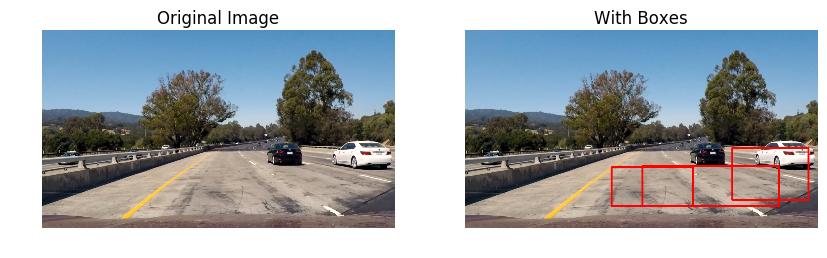

In [15]:
boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.004)
final = draw_boxes(boxes, test_image, ((500,1280),(300,650)))

plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")

(720, 1280, 3)


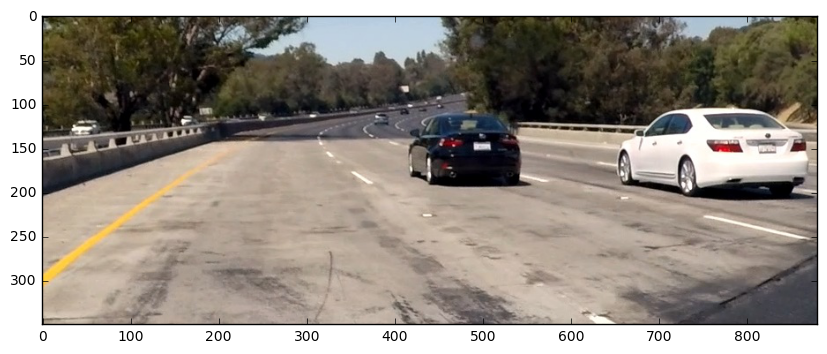

In [25]:
test_image = mpimg.imread('test_images/test1.jpg')
print (test_image.shape)
cropped = test_image[300:650,400:,:]
plt.imshow(cropped)
# cropped= cv2.resize(cropped, (448,448))
# normalized = normalize(cropped)
# transposed = np.transpose(normalized, (2,0,1))
# print (transposed.shape)
# batch = np.expand_dims(transposed, axis=0)
# batch_output = model.predict(batch)
# batch_output.shape
# #plt.imshow(transposed)

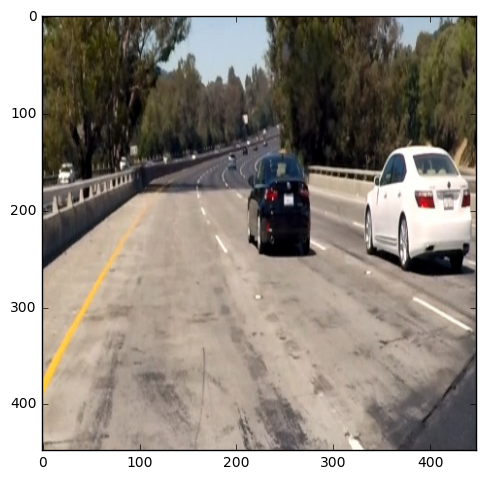

In [26]:
cropped= cv2.resize(cropped, (448,448))
plt.imshow(cropped)

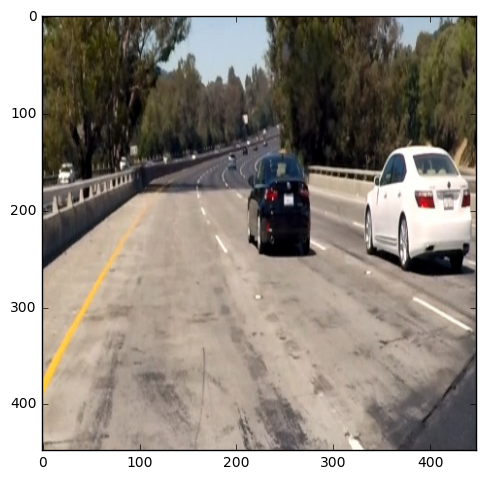

In [27]:
normalized = normalize(cropped)
plt.imshow(cropped)

In [30]:
batch = np.expand_dims(normalized.reshape((3,448,448)), axis=0)
batch_output = model.predict(batch)

In [33]:
print (batch_output.shape)
print (batch_output[0].shape)

(1, 1470)
(1470,)


In [41]:
boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.005)
boxes

 INside yolo_output_to_car_boxes 
========== Probabilities :  980
========  49 2
============== BOX_IOU  0.554292195062
============== BOX_IOU  0.546913477769
=========== Boxes  3


In [ ]:
final = draw_boxes(boxes, test_image, ((400,1280),(300,650)))

plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")

In [ ]:
boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.25)
boxes

In [ ]:
plt.imshow(normalized)

(531, 499) (827, 641)


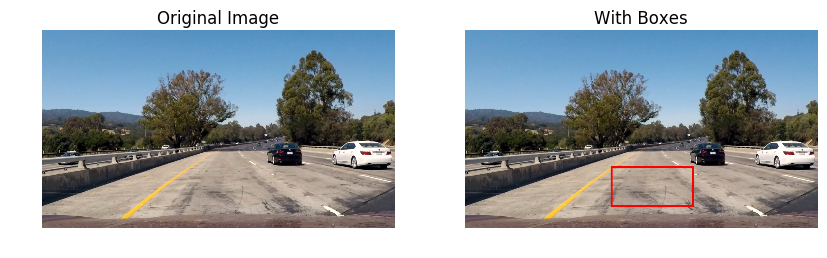

In [42]:
#boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.25)
final = draw_boxes(boxes, test_image, ((500,1280),(300,650)))

plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")